In [1]:
# 预处理：去趋势、带通滤波(300-3000Hz)、去噪、标准化
import numpy as np
from scipy.signal import detrend, butter, filtfilt
def preprocess_signal(signal, fs=10000, lowcut=300, highcut=3000):
    # 去趋势
    signal_detrended = detrend(signal)
    
    # 带通滤波
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    signal_filtered = filtfilt(b, a, signal_detrended)
    
    # 标准化
    signal_normalized = (signal_filtered - np.mean(signal_filtered, axis=-1).reshape(-1, 1)) / np.std(signal_filtered, axis=-1).reshape(-1, 1)

    return signal_normalized

In [2]:
import hdf5storage

brain_results= hdf5storage.loadmat('m39/brain_results.mat')
wholebrain_output=hdf5storage.loadmat('m39/wholebrain_output.mat')

brain_region= brain_results['brain_region']
# Primary visual area layer 1
pval1_index=[i for i in range(brain_region.shape[1]) if brain_region[0][i]=="Primary visual area layer 1"]

whole_trace_ori=wholebrain_output['whole_trace_ori']
pval1_trace_ori=whole_trace_ori[pval1_index,:]

whole_center=wholebrain_output['whole_center']
pval1_center=whole_center[pval1_index,:]


pval1_trace_ori_resting=pval1_trace_ori[:,40:2440]
pval1_trace_ori_anesthetized=pval1_trace_ori[:,4000:6400]
pval1_trace_ori_recovery=pval1_trace_ori[:,7800:10200]

In [3]:
# 预处理每个trace
resting_trace = preprocess_signal(pval1_trace_ori_resting)
anesthetized_trace = preprocess_signal(pval1_trace_ori_anesthetized)
recovery_trace = preprocess_signal(pval1_trace_ori_recovery)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# RNN with trainable modulated plasticity ("backpropamine")
class Network(nn.Module):
    
    def __init__(self, hsize=2205): 
        super(Network, self).__init__()
        self.hsize= hsize

        self.w =  torch.nn.Parameter(.001 * torch.rand(hsize, hsize))   # Baseline (non-plastic) component of the plastic recurrent layer
        
        self.alpha =  torch.nn.Parameter(.001 * torch.rand(hsize, hsize))   # Plasticity coefficients of the plastic recurrent layer; one alpha coefficient per recurrent connection
        #self.alpha = torch.nn.Parameter(.0001 * torch.rand(1,1,hsize))  # Per-neuron alpha
        #self.alpha = torch.nn.Parameter(.0001 * torch.ones(1))         # Single alpha for whole network

        self.h2mod = torch.nn.Linear(hsize, 1)      # Weights from the recurrent layer to the (single) neurodulator output
        self.modfanout = torch.nn.Linear(1, hsize)  # The modulator output is passed through a different 'weight' for each neuron (it 'fans out' over neurons)


        
    def forward(self, inputs, hidden): # hidden is a tuple containing the h-state (i.e. the recurrent hidden state) and the hebbian trace 
            HS = self.hsize
        
            # hidden[0] is the h-state; hidden[1] is the Hebbian trace
            hebb = hidden[1]


            # Each *column* of w, alpha and hebb contains the inputs weights to a single neuron
            hactiv = torch.tanh( inputs + hidden[0].unsqueeze(1).bmm(self.w + torch.mul(self.alpha, hebb)).squeeze(1)  )  # Update the h-state

            # Now computing the Hebbian updates...
            deltahebb = torch.bmm(hidden[0].unsqueeze(2), hactiv.unsqueeze(1))  # Batched outer product of previous hidden state with new hidden state
            
            # We also need to compute the eta (the plasticity rate), wich is determined by neuromodulation
            # Note that this is "simple" neuromodulation.
            myeta = F.tanh(self.h2mod(hactiv)).unsqueeze(2)  # Shape: BatchSize x 1 x 1
            
            # The neuromodulated eta is passed through a vector of fanout weights, one per neuron.
            # Each *column* in w, hebb and alpha constitutes the inputs to a single cell.
            # For w and alpha, columns are 2nd dimension (i.e. dim 1); for hebb, it's dimension 2 (dimension 0 is batch)
            # The output of the following line has shape BatchSize x 1 x NHidden, i.e. 1 line and NHidden columns for each 
            # batch element. When multiplying by hebb (BatchSize x NHidden x NHidden), broadcasting will provide a different
            # value for each cell but the same value for all inputs of a cell, as required by fanout concept.
            myeta = self.modfanout(myeta) 
            
            
            # Updating Hebbian traces, with a hard clip (other choices are possible)
            self.clipval = 2.0
            hebb = torch.clamp(hebb + myeta * deltahebb, min=-self.clipval, max=self.clipval)

            hidden = (hactiv, hebb)

            activout = hactiv

            self.hebb_for_neurons=hebb

            return activout,hidden

In [18]:
# compute small world network metrics
import networkx as nx
def compute_small_world_metrics(weights):
    # Create a directed graph from the weights
    G = nx.from_numpy_array(weights, create_using=nx.DiGraph)
    
    # Compute small-world metrics
    clustering_coefficient = nx.average_clustering(G.to_undirected())
    path_length = nx.average_shortest_path_length(G.to_undirected())
    
    return clustering_coefficient, path_length

In [6]:
#device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Network()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [7]:
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"Layer {name} is frozen!")
    else:
        print(f"Layer {name} is trainable with shape {param.shape}")

Layer w is trainable with shape torch.Size([2205, 2205])
Layer alpha is trainable with shape torch.Size([2205, 2205])
Layer h2mod.weight is trainable with shape torch.Size([1, 2205])
Layer h2mod.bias is trainable with shape torch.Size([1])
Layer modfanout.weight is trainable with shape torch.Size([2205, 1])
Layer modfanout.bias is trainable with shape torch.Size([2205])


In [ ]:

from tqdm import tqdm
def train_model(model, data, optimizer, criterion, epochs=10):
    # data [seq_len, hidden_size(number of neurons):2205]
    data = torch.tensor(data, dtype=torch.float32).to(device)  # Convert data to tensor and move to device
    model.train()
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        losses=[]
        hidden = (torch.zeros(1, model.hsize), torch.zeros(1, model.hsize, model.hsize))  # Initial hidden state
        hidden = (hidden[0].to(device), hidden[1].to(device))  # Move hidden state to device
        for step in tqdm(range(len(data) - 1), desc="Training Steps"):
            inputs = data[step].unsqueeze(0) #(1, 2205)
            optimizer.zero_grad()
            outputs, hidden = model(inputs, hidden)
            hidden = (hidden[0].detach(), hidden[1].detach()) # Detach hidden state to prevent backpropagation through it
            loss = criterion(outputs, data[step+1].unsqueeze(0))
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f'Epoch {epoch}, Loss: {np.mean(losses)}')

In [26]:
import numpy
def compute_and_plot():
    weight=model.w.detach()
    alpha=model.alpha.detach()
    hebb=model.hebb_for_neurons.detach().squeeze(0)  # Remove the batch dimension
    modfanout=model.modfanout.weight.detach().squeeze(1)  # Remove the batch dimension

    weight=weight.cpu().numpy()
    alpha=alpha.cpu().numpy()
    hebb=hebb.cpu().numpy()
    modfanout=modfanout.cpu().numpy()

    print(f'Weight shape: {weight.shape}, Alpha shape: {alpha.shape}, Hebb shape: {hebb.shape}')

    final_weights = weight + alpha * hebb

    print(f'Final Weights shape: {final_weights.shape}')

    # abs
    final_weights = numpy.abs(final_weights)
    # normalize
    final_weights = final_weights / numpy.max(final_weights)
    # Ensure the final weights are a numpy array
    if not isinstance(final_weights, numpy.ndarray):
        final_weights = numpy.array(final_weights)
    # binary thresholding
    threshold = numpy.mean(final_weights)  # You can adjust the threshold as needed
    final_weights = (final_weights > threshold).astype(int)

    #abs
    modfanout = numpy.abs(modfanout)
    # normalize modfanout
    modfanout = modfanout / numpy.max(modfanout)
    # Ensure modfanout is a numpy array
    if not isinstance(modfanout, numpy.ndarray):
        modfanout = numpy.array(modfanout)
    # binary thresholding for modfanout
    modfanout = (modfanout > numpy.mean(modfanout)).astype(int)

    # Compute small-world metrics for the resting state
    clustering_coefficient, path_length = compute_small_world_metrics(final_weights)
    print(f'Resting State - Clustering Coefficient: {clustering_coefficient}, Path Length: {path_length}')
    print(f'Resting State - Small-world-theta: {clustering_coefficient / path_length}')
    # plot the weights matrix
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    plt.imshow(final_weights, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Weights Matrix')
    plt.show()
    # plot myeta fanout (bar)
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(modfanout)), modfanout, color='blue')
    plt.title('Myeta Fanout Weights')
    plt.xlabel('Neuron Index')
    plt.ylabel('Fanout Weight')
    plt.show()

In [ ]:
# Train the model with resting data
train_model(model, torch.tensor(resting_trace, dtype=torch.float32).transpose(0,1), optimizer, criterion, epochs=10)

/tmp/ipykernel_16742/1074056031.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).to(device)  # Convert data to tensor and move to device
Training Progress:  10%|█         | 1/10 [00:00<00:03,  2.93it/s]

Epoch 0, Loss: 0.5202745199203491
Epoch 0, Loss: 0.469153568148613
Epoch 0, Loss: 0.6191423237323761
Epoch 0, Loss: 0.7533855065703392
Epoch 0, Loss: 0.8456357419490814
Epoch 0, Loss: 0.846369152267774
Epoch 0, Loss: 0.834989960704531
Epoch 0, Loss: 0.8236535079777241
Epoch 0, Loss: 0.8144302202595605


Training Steps: 100%|██████████| 9/9 [00:00<00:00, 130.74it/s]

Epoch 1, Loss: 0.5202745199203491
Epoch 1, Loss: 0.4668647199869156
Epoch 1, Loss: 0.6147768398125967
Epoch 1, Loss: 0.743663601577282
Epoch 1, Loss: 0.8369777858257293
Epoch 1, Loss: 0.8480955511331558
Epoch 1, Loss: 0.8409858814307621
Epoch 1, Loss: 0.8359689675271511
Epoch 1, Loss: 0.8274258408281538



Training Progress:  30%|███       | 3/10 [00:00<00:01,  6.85it/s]

Epoch 2, Loss: 0.5202745199203491
Epoch 2, Loss: 0.4643331319093704
Epoch 2, Loss: 0.6108449002106985
Epoch 2, Loss: 0.7415608540177345
Epoch 2, Loss: 0.833543211221695
Epoch 2, Loss: 0.8421734919150671
Epoch 2, Loss: 0.8403845386845725
Epoch 2, Loss: 0.8408819995820522
Epoch 2, Loss: 0.838917742172877


Epoch 3, Loss: 0.5202745199203491
Epoch 3, Loss: 0.46195079386234283
Epoch 3, Loss: 0.6082686483860016
Epoch 3, Loss: 0.7328373119235039
Epoch 3, Loss: 0.8199317634105683
Epoch 3, Loss: 0.8351587404807409
Epoch 3, Loss: 0.8416905190263476


Training Steps: 100%|██████████| 9/9 [00:00<00:00, 136.12it/s]


Epoch 3, Loss: 0.849608164280653
Epoch 3, Loss: 0.8536092804537879


Epoch 4, Loss: 0.5202745199203491
Epoch 4, Loss: 0.46007005870342255
Epoch 4, Loss: 0.6055940687656403
Epoch 4, Loss: 0.7300159558653831
Epoch 4, Loss: 0.8197556674480438
Epoch 4, Loss: 0.8372952987750372
Epoch 4, Loss: 0.8456697676862989
Epoch 4, Loss: 0.8552328981459141


Training Progress:  50%|█████     | 5/10 [00:00<00:00,  9.14it/s]

Epoch 4, Loss: 0.8590642445617251


Epoch 5, Loss: 0.5202745199203491
Epoch 5, Loss: 0.45910750329494476
Epoch 5, Loss: 0.6054192086060842
Epoch 5, Loss: 0.7316190972924232
Epoch 5, Loss: 0.8267801105976105
Epoch 5, Loss: 0.8461349060138067
Epoch 5, Loss: 0.8524013459682465
Epoch 5, Loss: 0.8614620454609394


Training Steps: 100%|██████████| 9/9 [00:00<00:00, 136.35it/s]


Epoch 5, Loss: 0.8665696018271976


Epoch 6, Loss: 0.5202745199203491
Epoch 6, Loss: 0.45748116075992584
Epoch 6, Loss: 0.6048043866952261
Epoch 6, Loss: 0.7281248494982719
Epoch 6, Loss: 0.8192417323589325
Epoch 6, Loss: 0.8394214957952499
Epoch 6, Loss: 0.8501832016876766


Training Progress:  70%|███████   | 7/10 [00:00<00:00, 10.42it/s]

Epoch 6, Loss: 0.8642547465860844
Epoch 6, Loss: 0.8738486667474111


Epoch 7, Loss: 0.5202745199203491
Epoch 7, Loss: 0.45575423538684845
Epoch 7, Loss: 0.6033075352509817
Epoch 7, Loss: 0.7282880917191505
Epoch 7, Loss: 0.8188896715641022


Training Steps: 100%|██████████| 9/9 [00:00<00:00, 106.48it/s]


Epoch 7, Loss: 0.8394060184558233
Epoch 7, Loss: 0.8530653928007398
Epoch 7, Loss: 0.8703641779720783
Epoch 7, Loss: 0.8812877900070615


Epoch 8, Loss: 0.5202745199203491
Epoch 8, Loss: 0.4545823782682419
Epoch 8, Loss: 0.600833386182785
Epoch 8, Loss: 0.72419223934412
Epoch 8, Loss: 0.8161316215991974
Epoch 8, Loss: 0.8370257467031479
Epoch 8, Loss: 0.8501826311860766


Training Progress:  90%|█████████ | 9/10 [00:00<00:00, 10.58it/s]

Epoch 8, Loss: 0.8676450438797474
Epoch 8, Loss: 0.8785993556181589


Epoch 9, Loss: 0.5202745199203491
Epoch 9, Loss: 0.4532548189163208
Epoch 9, Loss: 0.5994558135668436
Epoch 9, Loss: 0.7236392647027969
Epoch 9, Loss: 0.8138996243476868
Epoch 9, Loss: 0.835173100233078
Epoch 9, Loss: 0.8525323952947345


Training Progress: 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]

Epoch 9, Loss: 0.8739099279046059
Epoch 9, Loss: 0.8862382769584656


: 

Weight shape: (2205, 2205), Alpha shape: (2205, 2205), Hebb shape: (2205, 2205)
Final Weights shape: (2205, 2205)
Resting State - Clustering Coefficient: 0.7093371358731682, Path Length: 1.4009712293870966
Resting State - Small-world-theta: 0.506318132017238


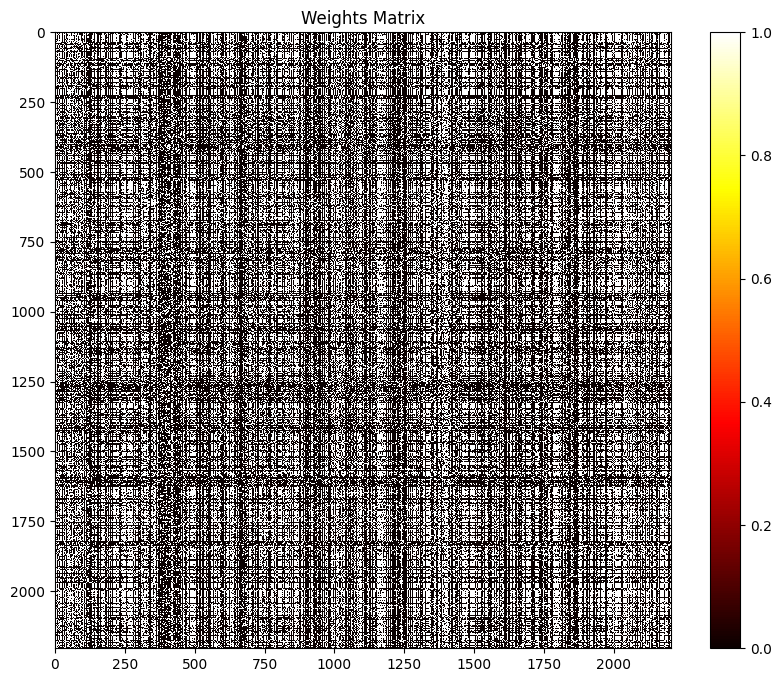

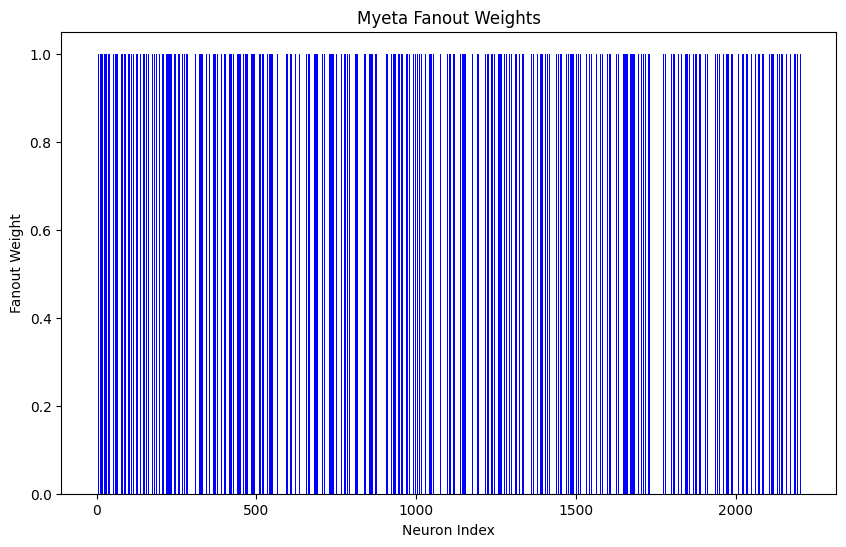

In [27]:
compute_and_plot()